In [120]:
from random import sample 
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from numpy import linalg as LA
import multiprocessing
import networkx as nx
from networkx.algorithms import bipartite
from networkx.algorithms import matching
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import phate
import itertools
import os
import re
import sys
import pickle
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import axes3d

np.set_printoptions(suppress=True)

In [2]:
# !pip install wordcloud
# !pip install phate
# !pip install tslearn
# !pip install tslearn

In [3]:
os.getcwd()

'/mnt/hdd/Dropbox (University of Michigan)/UMich/Research/twitter-covid/twitter-covid-topics/scripts'

In [214]:
data_path = "../learned_topics/TLDA/"

## Load all topic word distributions and merge

In [24]:
method = "exp_forg_smooth"
method_param = 0.75
filename = method + "_" + str(method_param) + "_t"
T = 50 # number of topics

In [25]:
trange = 89 # 89 for feb to may, 92 for may to aug, 180 for feb to aug
sdate = datetime(2020,2,14)
edate = datetime(2020,5,16)
datedelta = edate - sdate
days = [sdate + timedelta(days=i) for i in range(datedelta.days)]
dayStr = [str(sdate + timedelta(days=i))[0:10] for i in range(datedelta.days)]

In [26]:
days = days[0:trange]

In [11]:
# load word distributions for all topics across all timestamps
f = open(data_path + "WordsInTopicsAll" + "_" + method + "_" + str(method_param) + ".pkl", 'rb') 
WordsInTopicsAll = pickle.load(f)
WordsFreq = [[WordsInTopicsAll[t][i]["freq"].values for i in range(T)] for t in range(len(WordsInTopicsAll))]
f.close()

In [12]:
len(WordsInTopicsAll)

89

In [140]:
# load tweets volume for all topics across all timestamps
f = open(data_path + "TopicsCountsAll" + "_" + method + "_" + str(method_param) + ".pkl", 'rb') 
TopicsCountsAll = pickle.load(f)
f.close()

In [141]:
len(TopicsCountsAll)

89

## Visualize topics by word clouds

In [20]:
def plot_topics(t,topicInd="all",WordsInTopicsAll=WordsInTopicsAll):
    if topicInd == "all":
        T = len(WordsInTopicsAll[0])
        fig, axes = plt.subplots(nrows=int(T/3+1), ncols=3, figsize=(50,50))
        fig.subplots_adjust(hspace=0.5)

        for ax, topic in zip(axes.flatten(), np.arange(0,T,1)):
            d = {}
            for a, x in WordsInTopicsAll[t][topic].values:
                d[a] = x

            try:
                wordcloud = WordCloud(max_words=20,width=1000,height=500)
                wordcloud.generate_from_frequencies(frequencies=d)
                ax.imshow(wordcloud, interpolation="bilinear")
                ax.axis("off")
            except:
                print("topic" + str(topic) + " went wrong!")
    
        axes[-1,-1].axis("off") # turn off unused axis
        fig.tight_layout()
        plt.show()
    else:
        d = {}
        for a, x in WordsInTopicsAll[t][topicInd].values:
            d[a] = x

        wordcloud = WordCloud(max_words=50,width=1000,height=500)
        wordcloud.generate_from_frequencies(frequencies=d)

        plt.figure(facecolor='k')
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

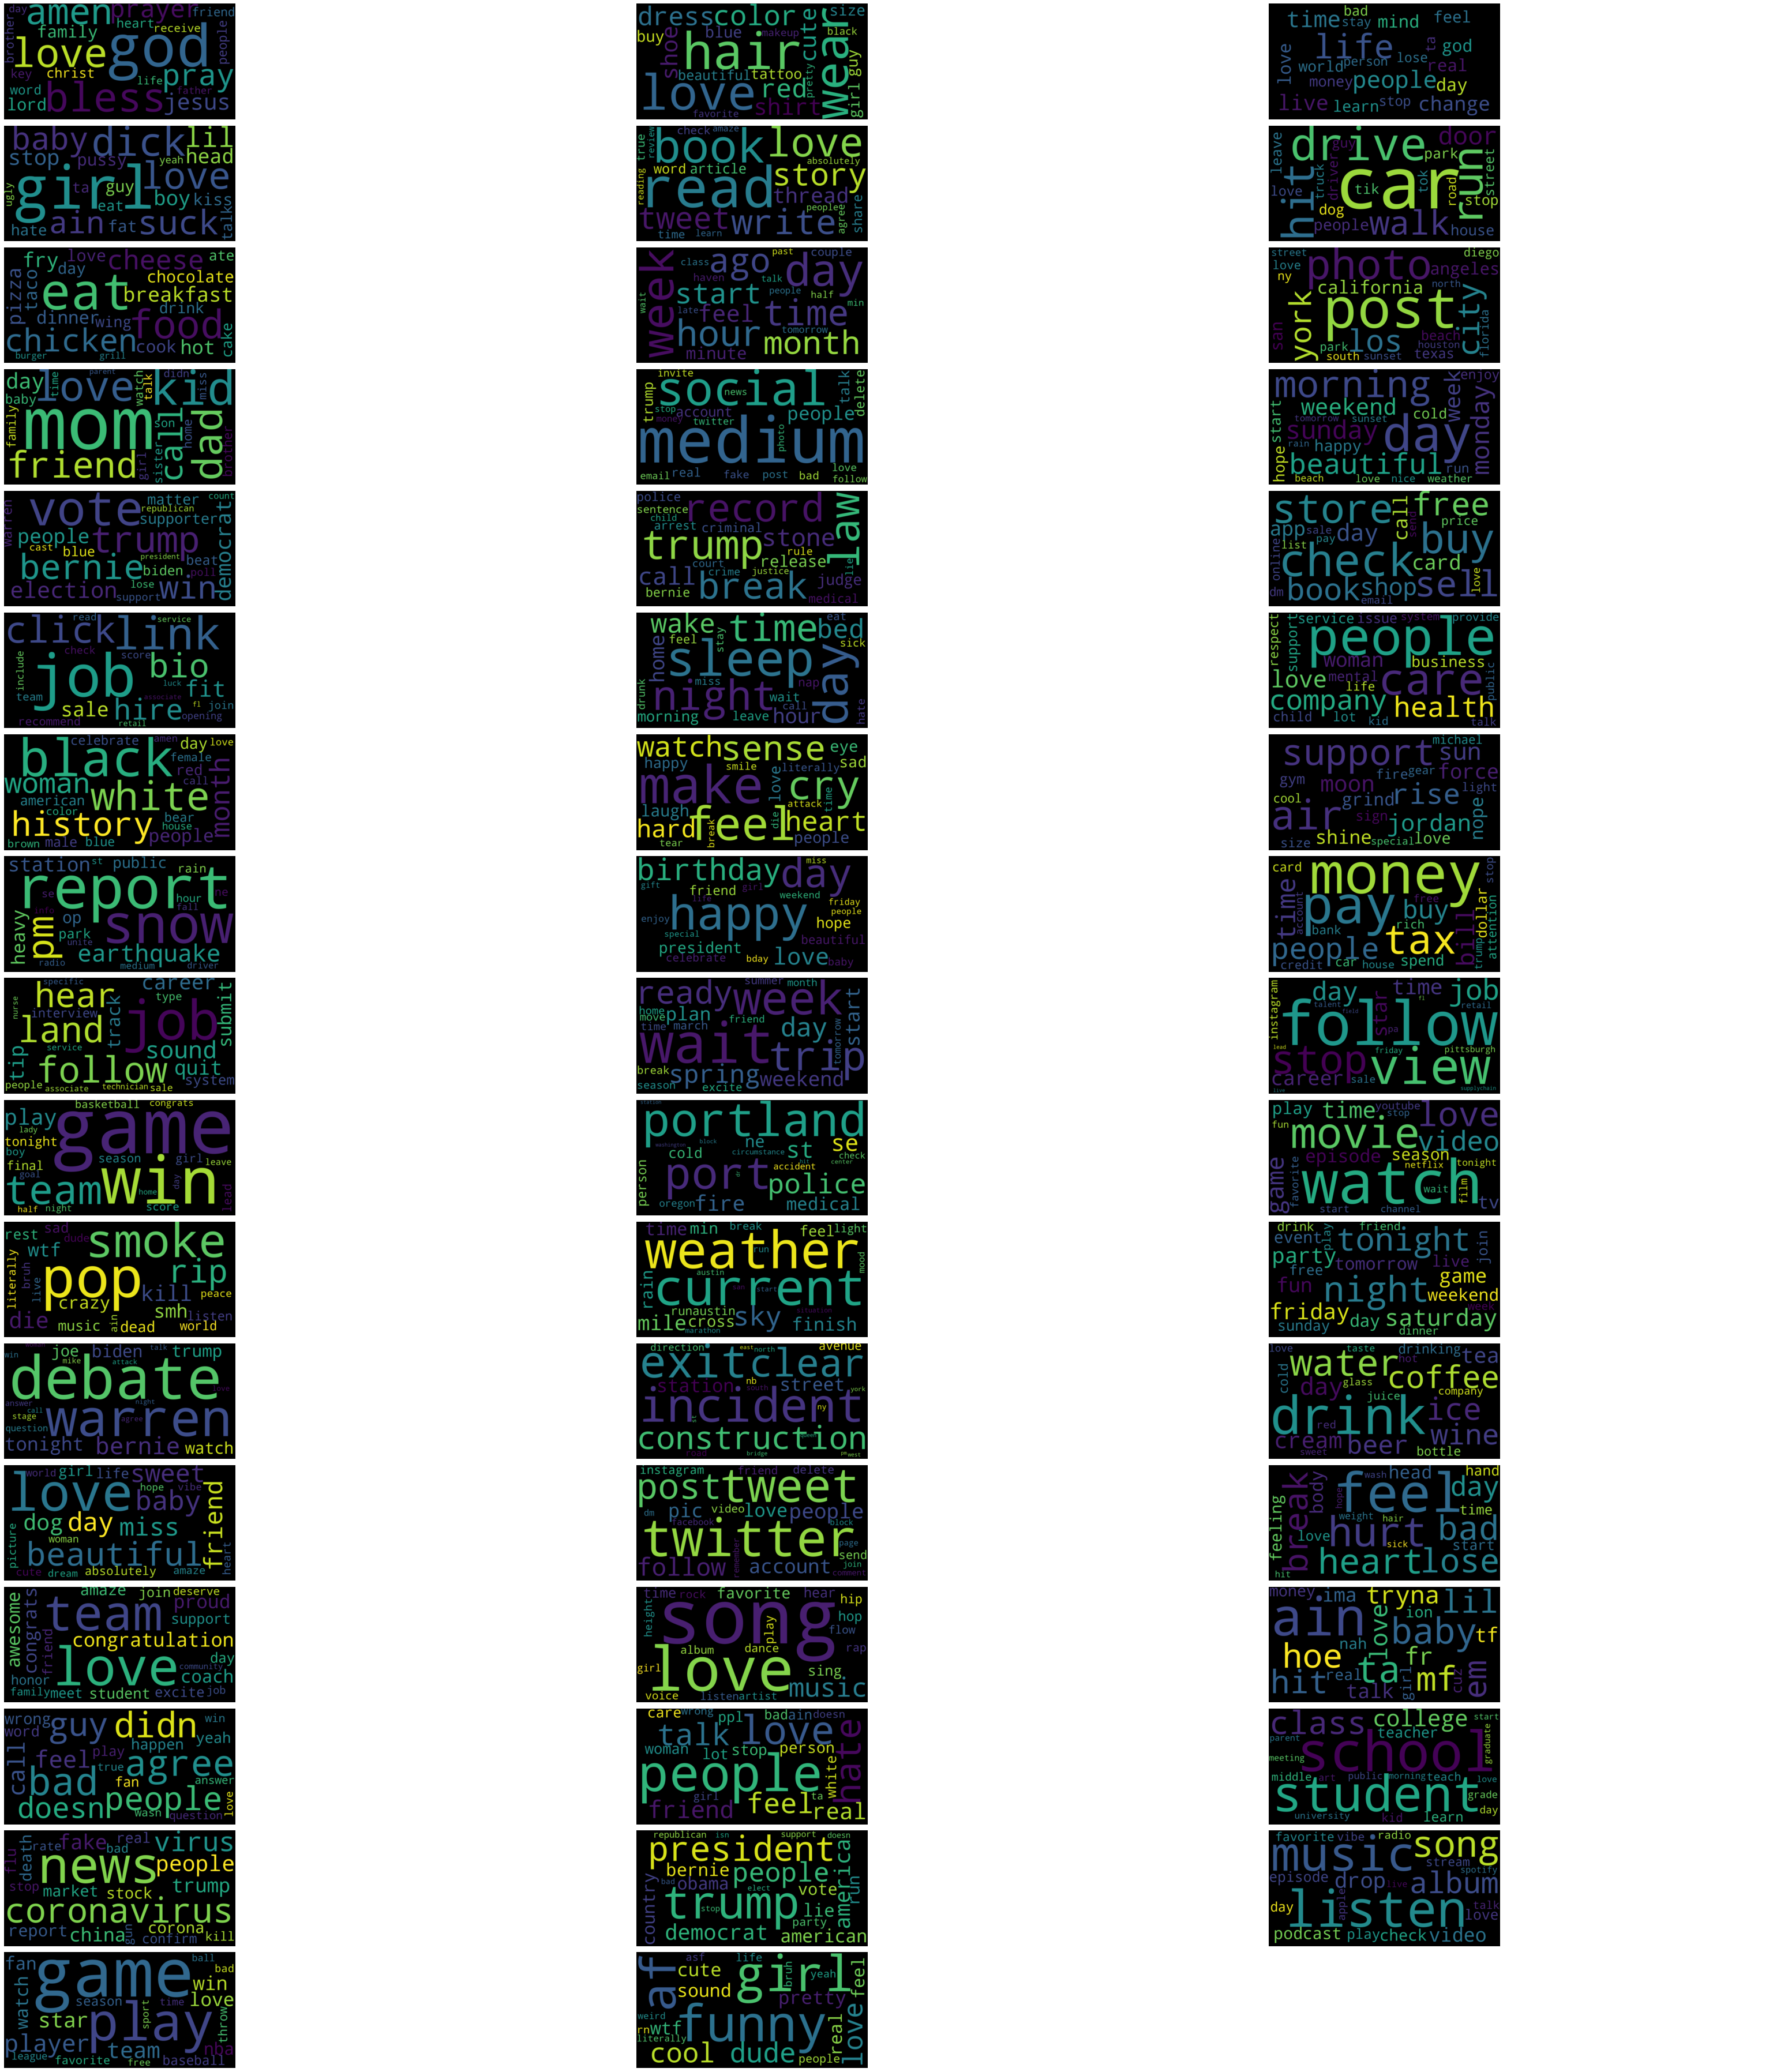

In [172]:
plot_topics(t=4)

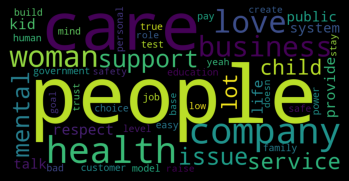

In [173]:
plot_topics(t=4,topicInd=17)

## Load Hellinger distance matrices

The Hellinger metric between two discrete probability distraibutions $p$ and $q$ is defined as:

$$
H(p,q) = \frac{1}{\sqrt{2}}\|\sqrt{p}-\sqrt{q}\|_2
$$

In [14]:
def hellinger(p,q):
    return np.linalg.norm(np.sqrt(p)-np.sqrt(q))/np.sqrt(2)

### Load k-nearest neighbors weights

In [22]:
# load results
k = 10
f = open(data_path + str(k) + "_nn_hellinger_dist" + "_" + method + "_" + str(method_param) + ".pkl", 'rb') 
nn_hellinger_mat = pickle.load(f)
f.close()
nn_hellinger_mat.shape

(4450, 4450)

### Find shortest path

In [23]:
def weights_path(start_node, start_day, distance=nn_hellinger_mat, trange=trange, phate=False):
    skips = []
    weights = []
    
    if phate:
        start_node += start_day*T
        path = [start_node] # for PHATE vis
    else:
        path = [start_node] # for plotting shortest path
        start_node += start_day*T
        
    for i in np.arange(start_day+1,trange):
        a = distance[start_node,:]
        Na = [n for n in range(len(a)) if a[n] != 0]
        try:
            a_next = [x for x in Na if x in range(i*T,i*T+T)]
            w_next = [a[x] for x in Na if x in range(i*T,i*T+T)]
            w_next_argmin = np.argmin(w_next)
            start_node = a_next[w_next_argmin]
            if phate:
                path.append(start_node) # save raw index for PHATE vis
            else:
                path.append(start_node-i*T) # save the topic number for a given day for shortest path
            weights.append(w_next[w_next_argmin])
        except Exception:
            skips.append(i)
            path.append(-100)
            continue
    return path, weights, skips

In [50]:
day = 0
edge = 35
path_covid, weights_covid, skips_covid = weights_path(edge,day,phate=False)
path_covid_phate, _, _ = weights_path(edge,day,phate=True)
path_covid_time_topic_list = [[np.arange(trange)[t]+day,path_covid[t],path_covid_phate[t]] for t in range(len(path_covid)) if path_covid[t] != -100]
path_covid_time_topic_df = pd.DataFrame(path_covid_time_topic_list)

In [83]:
path_covid_time_topic_df.head(20)

0   1     2
0    0  35    35
1    2  30   130
2    3   0   150
3    4  45   245
4    6  16   316
5    7  30   380
6    8   7   407
7    9  13   463
8   10  31   531
9   11   2   552
10  12  12   612
11  13  17   667
12  14  33   733
13  15   6   756
14  16  43   843
15  17  45   895
16  18  47   947
17  19  47   997
18  20  39  1039
19  21  24  1074

In [65]:
path_covid_time_topic_df.to_csv(data_path + "path_covid_time_topic_" + method + "_" + str(method_param) + "_" + str(k) + "_nn.txt", header=None)

In [176]:
day = 4
edge = 17
path_health_care, weights_health_care, skips_health_care = weights_path(edge,day,phate=False) 
path_health_care_phate, _, _ = weights_path(edge,day,phate=True)
# append 3, -100, 130, 150, 217 to the beginning
# path_health_care = [3, -100, 30, 0, 17] + path_health_care
# path_health_care_phate = [3, -100, 130, 150, 217] + path_health_care_phate
path_health_care_time_topic_list = [[np.arange(trange)[t]+day,path_health_care[t],path_health_care_phate[t]] for t in range(len(path_health_care)) if path_health_care[t] != -100]
path_health_care_time_topic_df = pd.DataFrame(path_health_care_time_topic_list)

In [177]:
path_health_care_time_topic_df.head(20)

0   1     2
0    4  17   217
1    5  46   296
2    7  28   378
3    8  48   448
4   11  31   581
5   12   1   601
6   13  23   673
7   15  24   774
8   16  29   829
9   17  26   876
10  18  17   917
11  20  17  1017
12  22  32  1132
13  23  24  1174
14  24  49  1249
15  28  22  1422
16  29  40  1490
17  30  33  1533
18  31  17  1567
19  32  28  1628

### Plot wordclouds of paths

In [92]:
def plot_topic_path(path_time_topic_df):
    path_topic_ind = path_time_topic_df[1].values
    path_time_ind = path_time_topic_df[0].values
    for t in range(len(path_time_ind)):
        d = {}
        for a, x in WordsInTopicsAll[path_time_ind[t]][path_topic_ind[t]].values:
            d[a] = x

        wordcloud = WordCloud(max_words=30)
        wordcloud.generate_from_frequencies(frequencies=d)
        plt.figure(facecolor='k') 
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

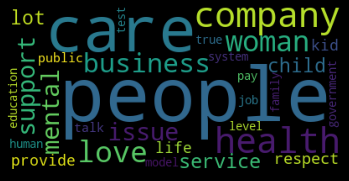

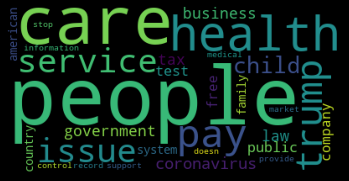

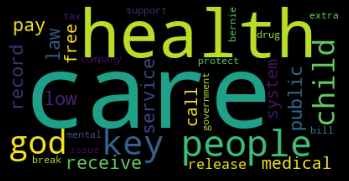

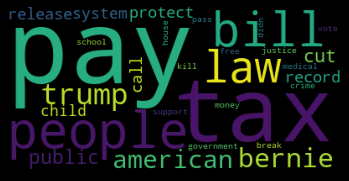

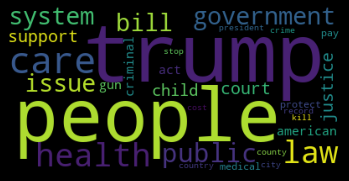

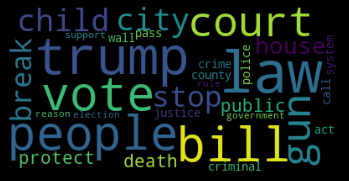

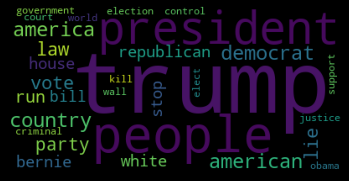

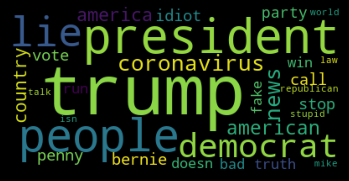

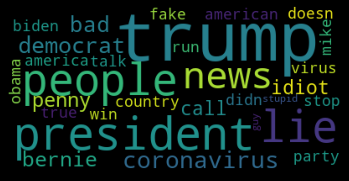

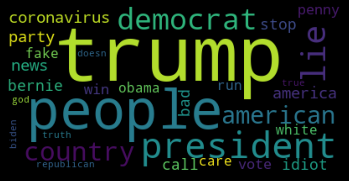

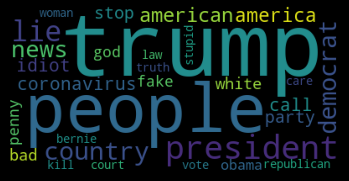

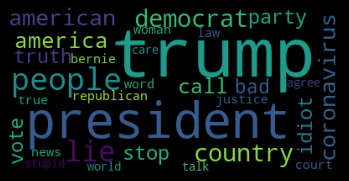

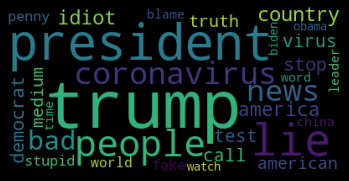

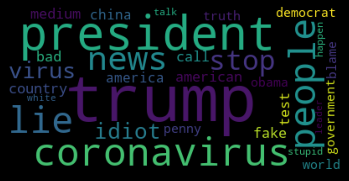

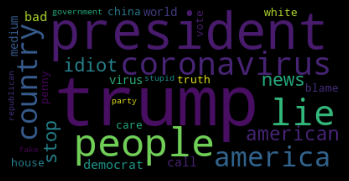

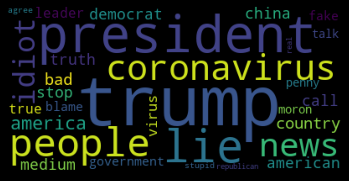

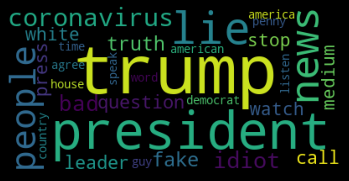

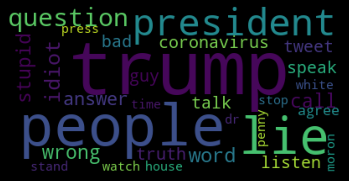

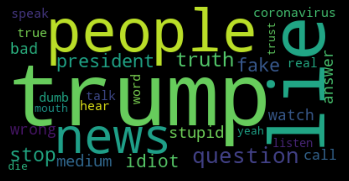

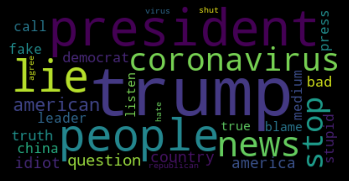

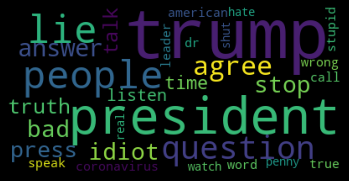

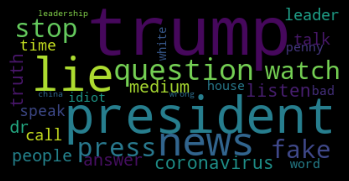

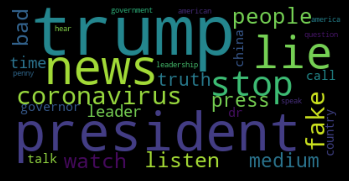

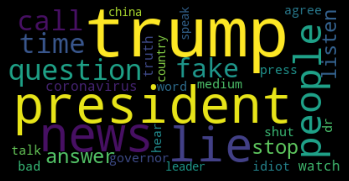

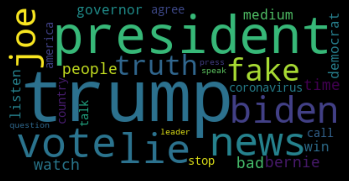

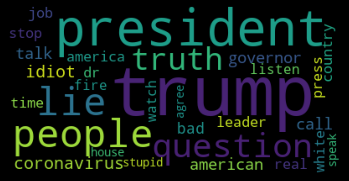

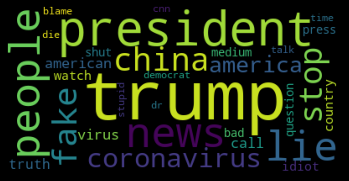

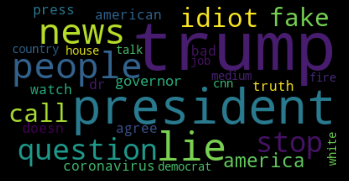

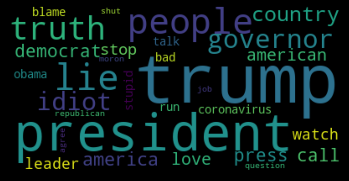

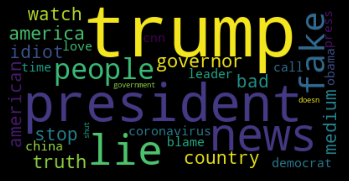

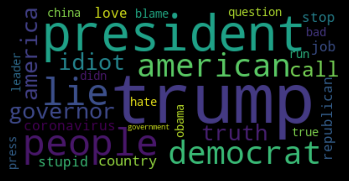

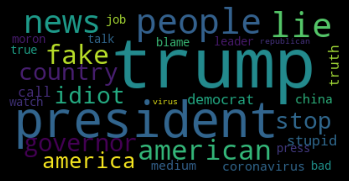

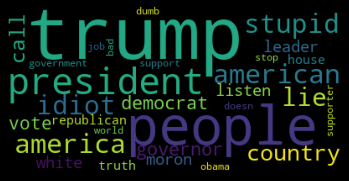

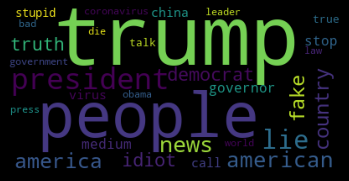

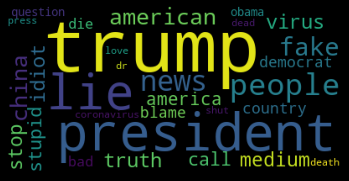

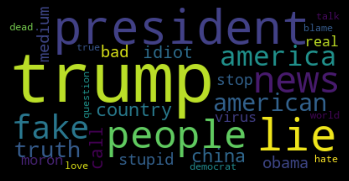

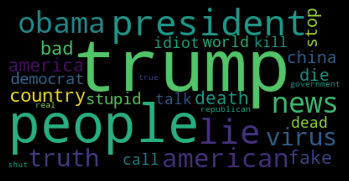

In [178]:
plot_topic_path(path_health_care_time_topic_df)

## PHATE visualizaiton

In [94]:
# load full hellinger distance matrix
f = open(data_path + "hellinger_dist" + "_" + method + "_" + str(method_param) + ".pkl", 'rb') 
hellinger_dist = pickle.load(f)
f.close()
hellinger_dist.shape

(4450, 4450)

### Global clustering of all topics

In [95]:
# Hierarchical clustering for topics across time
# Use precomputed Hellinger distance matrix
def hier_cluster(distance=hellinger_dist, n_clusters=60):
    cl = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='average')
    cl.fit(distance)
    return(cl.labels_)

In [97]:
labs = hier_cluster(distance=hellinger_dist)

In [99]:
# find all topics belong to certain cluster
def find_topics_in_cluster(topic_ind,start_day,labs=labs):
    cl_ind = [i for i in range(len(labs)) if labs[i]==labs[start_day*T+topic_ind]]
    return cl_ind

In [105]:
covid_cl_ind = find_topics_in_cluster(path_covid_time_topic_df[1].values[0],path_covid_time_topic_df[0].values[0])

In [106]:
len(covid_cl_ind)

198

In [107]:
covid_news_cl_ind = find_topics_in_cluster(path_election_time_topic_df[1].values[0],path_election_time_topic_df[0].values[0])

In [108]:
len(covid_news_cl_ind)

272

In [110]:
wash_hands_cl_ind = find_topics_in_cluster(path_wash_hands_time_topic_df[1].values[0],path_wash_hands_time_topic_df[0].values[0])

In [111]:
len(wash_hands_cl_ind)

69

In [112]:
stay_home_cl_ind = find_topics_in_cluster(path_stay_home_time_topic_df[1].values[0],path_stay_home_time_topic_df[0].values[0])

In [113]:
len(stay_home_cl_ind)

77

In [114]:
# Creating cluster/path labels for all topics
def create_cluster_path_labs(cl_ind_dict,path_ind_dict):
    cluster = ["OTHER" for i in range(len(labs))]
    path = ["OTHER" for i in range(len(labs))]
    
    if len(cl_ind_dict) > 0: 
        for i in cl_ind_dict:
            cl_ind = cl_ind_dict[i]
            for j in range(len(cl_ind)):
                cluster[cl_ind[j]] = str(i)
    
    if len(path_ind_dict) > 0:
        for i in path_ind_dict:
            path_ind = path_ind_dict[i]
            for j in range(len(path_ind)):
                path[path_ind[j]] = str(i)
            
    return cluster, path

In [193]:
cl_ind_dict = {"COVID NEWS":covid_news_cl_ind,
              "COVID":covid_cl_ind,
              "SANITIZING":wash_hands_cl_ind,
              "STAY HOME":stay_home_cl_ind}
path_ind_dict = {"COVID NEWS (presidential election)":path_election_time_topic_df[2].values,
                "COVID (health care)":path_covid_time_topic_df[2].values,
                "COVID (politics)":path_health_care_time_topic_df[2].values,
                "STAY HOME (executive order)":path_stay_home_time_topic_df[2].values,
                "SANITIZING (wash hands)":path_wash_hands_time_topic_df[2].values}

In [194]:
cluster, path = create_cluster_path_labs(cl_ind_dict,path_ind_dict)

### PHATE 

In [121]:
# One-step final PHATE
# phate_operator = phate.PHATE(n_components=3, knn=10, decay=10, knn_dist="precomputed", mds="nonmetric")
phate_operator = phate.PHATE(n_components=3, knn=10, knn_dist="precomputed")
phate_res = phate_operator.fit_transform(hellinger_dist) # compute the final embedding

Calculating PHATE...
  Running PHATE on precomputed distance matrix with 4450 observations.
  Calculating graph and diffusion operator...
    Calculating affinities...
    Calculated affinities in 1.36 seconds.
  Calculated graph and diffusion operator in 1.71 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.78 seconds.
    Calculating KMeans...
    Calculated KMeans in 12.40 seconds.
  Calculated landmark operator in 13.82 seconds.
  Calculating optimal t...
    Automatically selected t = 30
  Calculated optimal t in 1.14 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.68 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 52.71 seconds.
Calculated PHATE in 70.08 seconds.


In [200]:
phate_df = pd.DataFrame({"phate-3d-one":phate_res[:,0],"phate-3d-two":phate_res[:,1],"phate-3d-three":phate_res[:,2]})
phate_df["cluster"] = cluster
phate_df["path"] = path
phate_df["days"] = [d for d in range(trange) for t in range(T)] 
phate_df["volume"] = list(itertools.chain(*TopicsCountsAll))

In [201]:
phate_df.head()

phate-3d-one  phate-3d-two  phate-3d-three cluster   path  days    volume
0      0.000333     -0.009727        0.003061   OTHER  OTHER     0  0.039624
1     -0.010071     -0.001224       -0.008069   OTHER  OTHER     0  0.015353
2     -0.005799     -0.009453        0.006775   OTHER  OTHER     0  0.028056
3     -0.007244      0.013765        0.003971   COVID  OTHER     0  0.014070
4     -0.001561      0.002573       -0.008063   OTHER  OTHER     0  0.018695

In [202]:
def plot_phate(df,color="cluster",style="path",size="volume",legend_loc="upper right"):
    plt.figure(figsize=(10,10))
    sns.scatterplot(
        x="phate-3d-one", y="phate-3d-two",
        hue=color,
        style=style,
        size=size,
        sizes=(10, 100),
        palette="viridis",
        data=df,
    )
    plt.legend(loc=legend_loc)
    plt.xlabel("PHATE1")
    plt.ylabel("PHATE2")
    plt.show()

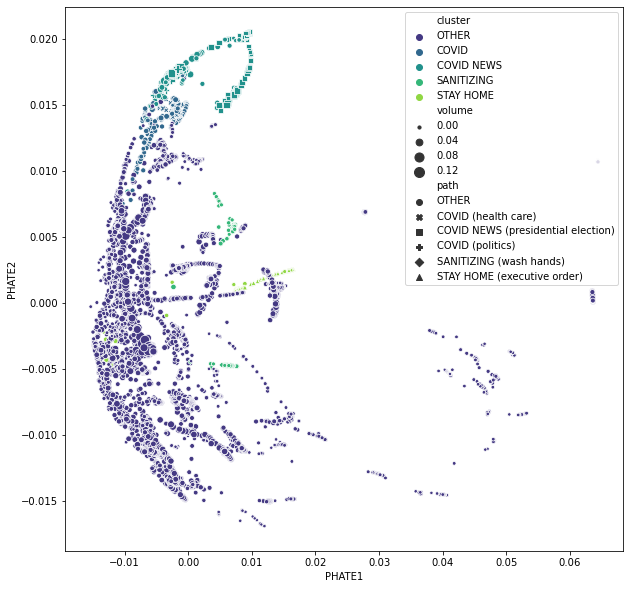

In [203]:
plot_phate(phate_df)

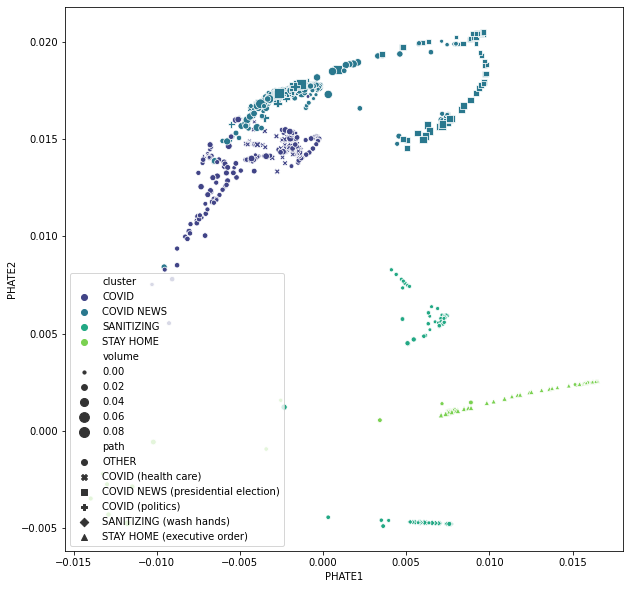

In [204]:
plot_phate(phate_df[(phate_df["cluster"]!="OTHER")], legend_loc="lower left")

## Individual cluster/path analysis

In [208]:
def plot_individual_phate(df,color="days",style="path",size="volume"):
    df["phate-3d-one"] = 100*df['phate-3d-one'].values 
    df["phate-3d-two"] = 100*df['phate-3d-two'].values

    # plot the chart
    plt.figure(figsize=(10,10))

    # plot all other points
    sns.scatterplot(x="phate-3d-one", 
                    y="phate-3d-two",
                    hue=color,
                    style=style,
                    size=size, 
                    sizes=(10,500), 
                    palette="viridis", 
                    data=df)

    plt.xlabel("PHATE1")
    plt.ylabel("PHATE2")
    plt.show()

### COVID NEWS (presidential election) trajectory

<ipython-input-208-65903ad115fa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["phate-3d-one"] = 100*df['phate-3d-one'].values
<ipython-input-208-65903ad115fa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["phate-3d-two"] = 100*df['phate-3d-two'].values


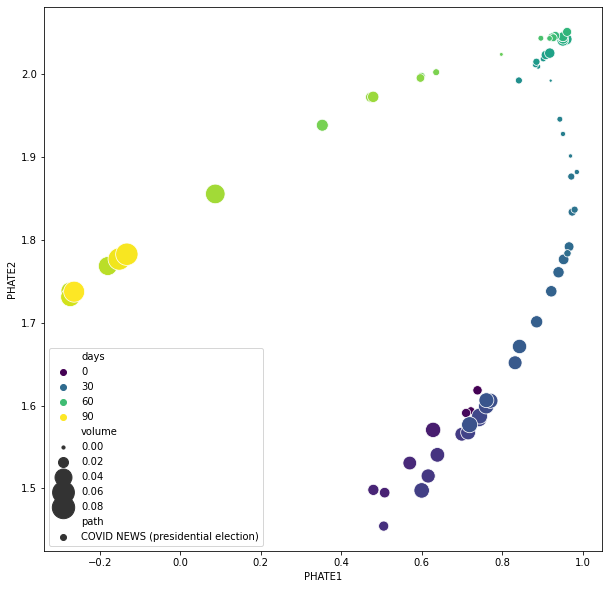

In [209]:
plot_individual_phate(phate_df[(phate_df["path"]=="COVID NEWS (presidential election)")])

### Stay-at-home trajectory

<ipython-input-208-65903ad115fa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["phate-3d-one"] = 100*df['phate-3d-one'].values
<ipython-input-208-65903ad115fa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["phate-3d-two"] = 100*df['phate-3d-two'].values


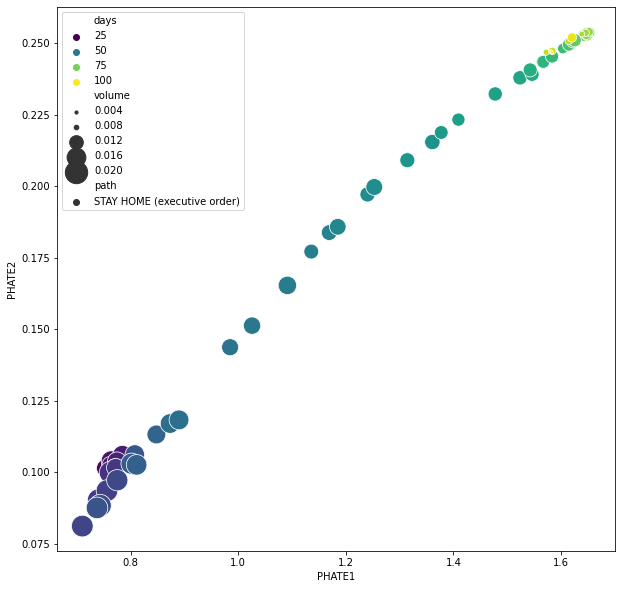

In [210]:
plot_individual_phate(phate_df[phate_df["path"]=="STAY HOME (executive order)"])

### COVID (politics) and COVID (health care) trajectory

<ipython-input-208-65903ad115fa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["phate-3d-one"] = 100*df['phate-3d-one'].values
<ipython-input-208-65903ad115fa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["phate-3d-two"] = 100*df['phate-3d-two'].values


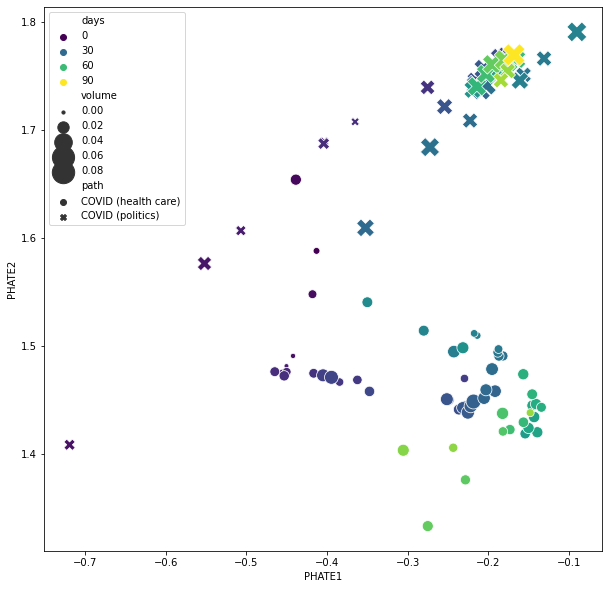

In [211]:
plot_individual_phate(phate_df[(phate_df["path"]=="COVID (politics)") | (phate_df["path"]=="COVID (health care)")])

#### 3D PHATE

In [212]:
def plot_individual_phate_3d(df):
    df_sub_path = df[df["path"]=="COVID (health care)"]
    xs = 100*df_sub_path['phate-3d-one'].values 
    ys = 100*df_sub_path['phate-3d-two'].values
    zs = 100*df_sub_path['phate-3d-three'].values
    d = df_sub_path['days'].values
    v = 5000*df_sub_path['volume'].values

    fig = plt.figure(figsize=(10,10))
    ax = Axes3D(fig)
    ax.scatter(xs,ys,zs,c=d,s=v,cmap="viridis")

    df_sub_path = df[df["path"]=="COVID (politics)"]
    xs = 100*df_sub_path['phate-3d-one'].values 
    ys = 100*df_sub_path['phate-3d-two'].values
    zs = 100*df_sub_path['phate-3d-three'].values
    d = df_sub_path['days'].values
    v = 5000*df_sub_path['volume'].values

    ax.scatter(xs,ys,zs,c=d,s=v,cmap="viridis",marker="X")

    # BG setting
    # Get rid of colored axes planes
    # First remove fill
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    # Now set color to white (or whatever is "invisible")
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    # Bonus: To get rid of the grid as well:
    #     ax.grid(False)

    # rotate the axes 
    ax.view_init(-10,180)

    plt.show()

    # save
    # plt.savefig("../../twitter-covid-report/covid-trajectory-3d.png")

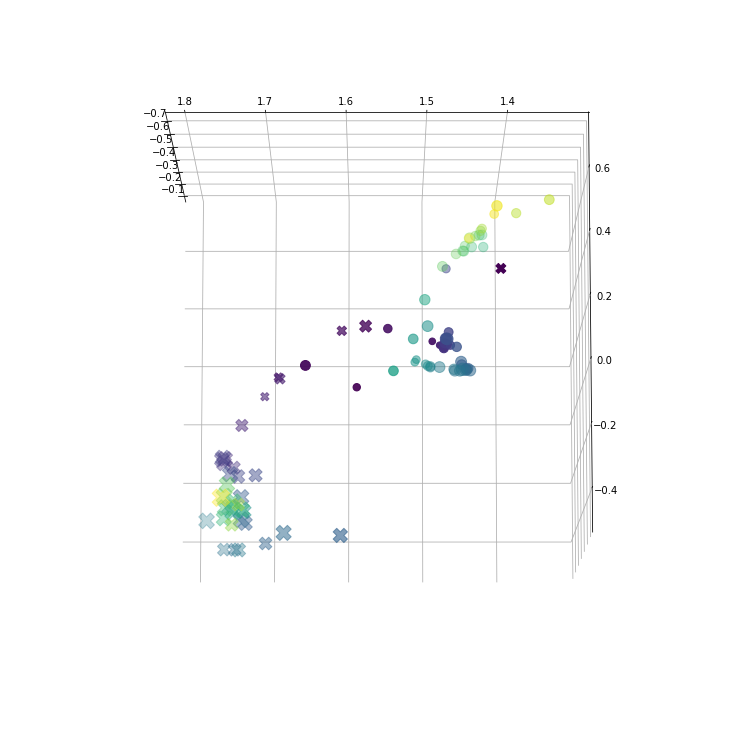

In [213]:
plot_individual_phate_3d(phate_df)